## Load the Dataset

In [1]:
from rag.load import load_benchmark_corpus, corpus_to_texts_metadatas


benchmark, corpus = load_benchmark_corpus()
texts, metadatas = corpus_to_texts_metadatas(corpus)

In [2]:
from rag.chunk import create_documents


documents = create_documents(
    "Qwen/Qwen3-Embedding-8B",
    texts, metadatas,
    chunk_size=500,
    atom_size=200,
)
documents[:5]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

[Document(metadata={'source_file': 'Fiverr.txt', 'start_index': 0}, page_content='  At Fiverr we care about your privacy.'),
 Document(metadata={'source_file': 'Fiverr.txt', 'start_index': 40}, page_content='We do not sell or rent your personal information to third parties for their direct marketing purposes without your explicit consent.\nWe do not disclose it to others except as disclosed in this Policy or required to provide you with the services of the Site and mobile applications, meaning - to allow you to buy, sell, share the information you want to share on the Site; to contribute on the forum; pay for products; post reviews and so on; or where we have a legal obligation to do so.'),
 Document(metadata={'source_file': 'Fiverr.txt', 'start_index': 528}, page_content='  We collect information that you provide us or voluntarily share with other users, and also some general technical information that is automatically gathered by our systems, such as IP address, browser information a

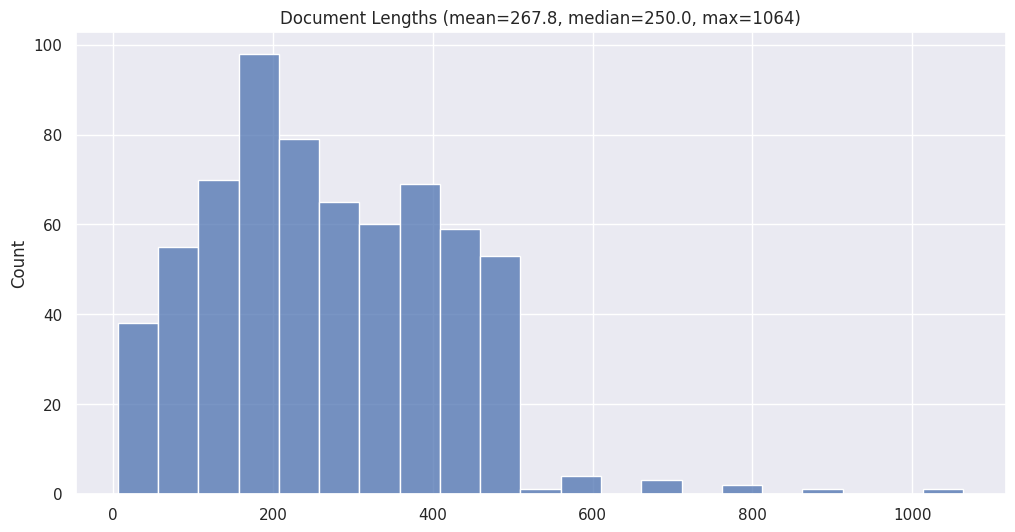

In [3]:
%matplotlib inline

import statistics
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_theme()

lengths = [len(doc.page_content) for doc in documents]

plt.figure(figsize=(12, 6))
sns.histplot(lengths)
plt.title(f"Document Lengths (mean={statistics.mean(lengths):.1f}, median={statistics.median(lengths):.1f}, max={max(lengths)})")
plt.show()

In [4]:
from rag.embed import compute_similarities, get_query_strings, get_document_contents

similarities = compute_similarities(
    "Qwen/Qwen3-Embedding-8B",
    queries=get_query_strings(benchmark),
    documents=get_document_contents(documents),
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/21 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
import torch

from rag.metrics import print_evaluations


ranks = torch.argsort(similarities, descending=True)

print("Baseline Evaluation")
print_evaluations(benchmark, documents, ranks)

Baseline Evaluation
precision @ 1 :  0.2792, recall @ 1 :  0.1391
precision @ 2 :  0.2315, recall @ 2 :  0.1941
precision @ 4 :  0.1985, recall @ 4 :  0.2815
precision @ 8 :  0.1567, recall @ 8 :  0.4318
precision @ 16:  0.1129, recall @ 16:  0.5714
precision @ 32:  0.0832, recall @ 32:  0.7550
precision @ 64:  0.0560, recall @ 64:  0.9118
AUC: 0.09505790538681338


In [6]:
from tqdm.notebook import tqdm
import torch

from rag.rerank import rerank


model_path = "ContextualAI/ctxl-rerank-v2-instruct-multilingual-2b"
TOP_K = 64

ranks = torch.argsort(similarities, descending=True)
reranks = rerank(benchmark, documents, ranks, model_path=model_path, topk=TOP_K)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

/home/joshuachin/miniconda3/envs/RAG-2/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:186: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


In [7]:
print(f"Reranked (K={TOP_K}) Evaluation")
print_evaluations(benchmark, documents, reranks)

Reranked (K=64) Evaluation
precision @ 1 :  0.3503, recall @ 1 :  0.1872
precision @ 2 :  0.3093, recall @ 2 :  0.2701
precision @ 4 :  0.2496, recall @ 4 :  0.3711
precision @ 8 :  0.1868, recall @ 8 :  0.5255
precision @ 16:  0.1314, recall @ 16:  0.6640
precision @ 32:  0.0868, recall @ 32:  0.8110
precision @ 64:  0.0560, recall @ 64:  0.9118
AUC: 0.14905464393659612
